# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

2022-05-20 17:30:32.360302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 17:30:32.360325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data

In [2]:
import pandas as pd 


In [3]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
print(data)
print("Features mean: %.2f" % (data.mean()))
print("Features std: %.2f" % (data.std()))
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
print("Features mean: %.2f" % (normalized_data.numpy().mean()))
print("Features std: %.2f" % (normalized_data.numpy().std()))

print(data)

[[ 0.14568704  0.99421215]
 [ 0.64766085 -0.44008517]
 [ 1.1260408  -0.50572985]
 ...
 [-0.8768747   0.49268788]
 [-0.94059974  0.3790682 ]
 [-1.0211023   0.16270489]]
Features mean: 0.37
Features std: 0.72


2022-05-20 17:30:35.151986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-20 17:30:35.152012: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 17:30:35.152030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MPC): /proc/driver/nvidia/version does not exist
2022-05-20 17:30:35.152226: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Features mean: -0.00
Features std: 1.00
[[ 0.14568704  0.99421215]
 [ 0.64766085 -0.44008517]
 [ 1.1260408  -0.50572985]
 ...
 [-0.8768747   0.49268788]
 [-0.94059974  0.3790682 ]
 [-1.0211023   0.16270489]]


In [4]:
df = pd.DataFrame(data)
df.describe()

,0,1
count,3000.000000,3000.000000
mean,0.499139,0.248878
std,0.868563,0.496244
min,-1.154920,-0.625034
25%,-0.048822,-0.212028
50%,0.496159,0.248178
75%,1.043659,0.693321
max,2.148676,1.132770


# Layer

In [5]:
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

# Real NVP

# Model training

In [6]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

# Model training

In [7]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2
)


Epoch 1/300


2022-05-20 17:30:37.164919: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


10/10 - 6s - loss: 2.6904 - val_loss: 2.6177 - 6s/epoch - 610ms/step
Epoch 2/300
10/10 - 1s - loss: 2.6016 - val_loss: 2.5661 - 542ms/epoch - 54ms/step
Epoch 3/300
10/10 - 1s - loss: 2.5491 - val_loss: 2.5199 - 502ms/epoch - 50ms/step
Epoch 4/300
10/10 - 0s - loss: 2.5108 - val_loss: 2.4800 - 408ms/epoch - 41ms/step
Epoch 5/300
10/10 - 1s - loss: 2.4835 - val_loss: 2.4496 - 544ms/epoch - 54ms/step
Epoch 6/300
10/10 - 1s - loss: 2.4555 - val_loss: 2.4245 - 526ms/epoch - 53ms/step
Epoch 7/300
10/10 - 1s - loss: 2.4275 - val_loss: 2.3799 - 500ms/epoch - 50ms/step
Epoch 8/300
10/10 - 0s - loss: 2.3964 - val_loss: 2.3477 - 398ms/epoch - 40ms/step
Epoch 9/300
10/10 - 1s - loss: 2.3678 - val_loss: 2.3306 - 518ms/epoch - 52ms/step
Epoch 10/300
10/10 - 1s - loss: 2.3439 - val_loss: 2.2947 - 549ms/epoch - 55ms/step
Epoch 11/300
10/10 - 1s - loss: 2.3212 - val_loss: 2.2781 - 525ms/epoch - 53ms/step
Epoch 12/300
10/10 - 0s - loss: 2.2967 - val_loss: 2.2658 - 413ms/epoch - 41ms/step
Epoch 13/300
10

Epoch 99/300
10/10 - 0s - loss: 1.3158 - val_loss: 1.2805 - 463ms/epoch - 46ms/step
Epoch 100/300
10/10 - 1s - loss: 1.2999 - val_loss: 1.2889 - 545ms/epoch - 55ms/step
Epoch 101/300
10/10 - 1s - loss: 1.3053 - val_loss: 1.3110 - 549ms/epoch - 55ms/step
Epoch 102/300
10/10 - 0s - loss: 1.3335 - val_loss: 1.2934 - 438ms/epoch - 44ms/step
Epoch 103/300
10/10 - 0s - loss: 1.3186 - val_loss: 1.2604 - 477ms/epoch - 48ms/step
Epoch 104/300
10/10 - 1s - loss: 1.3049 - val_loss: 1.2761 - 542ms/epoch - 54ms/step
Epoch 105/300
10/10 - 1s - loss: 1.3638 - val_loss: 1.4126 - 540ms/epoch - 54ms/step
Epoch 106/300
10/10 - 0s - loss: 1.3433 - val_loss: 1.3141 - 443ms/epoch - 44ms/step
Epoch 107/300
10/10 - 0s - loss: 1.3087 - val_loss: 1.3136 - 482ms/epoch - 48ms/step
Epoch 108/300
10/10 - 1s - loss: 1.3527 - val_loss: 1.3313 - 537ms/epoch - 54ms/step
Epoch 109/300
10/10 - 1s - loss: 1.3721 - val_loss: 1.3398 - 520ms/epoch - 52ms/step
Epoch 110/300
10/10 - 0s - loss: 1.3891 - val_loss: 1.2997 - 441ms

Epoch 196/300
10/10 - 0s - loss: 1.2156 - val_loss: 1.2226 - 412ms/epoch - 41ms/step
Epoch 197/300
10/10 - 1s - loss: 1.2363 - val_loss: 1.2018 - 553ms/epoch - 55ms/step
Epoch 198/300
10/10 - 1s - loss: 1.1893 - val_loss: 1.1669 - 561ms/epoch - 56ms/step
Epoch 199/300
10/10 - 1s - loss: 1.1821 - val_loss: 1.1891 - 535ms/epoch - 54ms/step
Epoch 200/300
10/10 - 0s - loss: 1.1935 - val_loss: 1.1778 - 432ms/epoch - 43ms/step
Epoch 201/300
10/10 - 1s - loss: 1.1973 - val_loss: 1.2039 - 548ms/epoch - 55ms/step
Epoch 202/300
10/10 - 1s - loss: 1.1904 - val_loss: 1.1862 - 574ms/epoch - 57ms/step
Epoch 203/300
10/10 - 0s - loss: 1.1838 - val_loss: 1.1841 - 496ms/epoch - 50ms/step
Epoch 204/300
10/10 - 0s - loss: 1.1807 - val_loss: 1.1852 - 474ms/epoch - 47ms/step
Epoch 205/300
10/10 - 1s - loss: 1.1951 - val_loss: 1.1976 - 549ms/epoch - 55ms/step
Epoch 206/300
10/10 - 1s - loss: 1.2094 - val_loss: 1.2513 - 554ms/epoch - 55ms/step
Epoch 207/300
10/10 - 0s - loss: 1.1933 - val_loss: 1.2399 - 464m

Epoch 293/300
10/10 - 0s - loss: 1.1706 - val_loss: 1.1617 - 417ms/epoch - 42ms/step
Epoch 294/300
10/10 - 1s - loss: 1.1677 - val_loss: 1.1531 - 526ms/epoch - 53ms/step
Epoch 295/300
10/10 - 1s - loss: 1.1662 - val_loss: 1.2023 - 547ms/epoch - 55ms/step
Epoch 296/300
10/10 - 1s - loss: 1.1716 - val_loss: 1.1585 - 535ms/epoch - 53ms/step
Epoch 297/300
10/10 - 0s - loss: 1.1755 - val_loss: 1.1912 - 406ms/epoch - 41ms/step
Epoch 298/300
10/10 - 1s - loss: 1.1763 - val_loss: 1.1829 - 542ms/epoch - 54ms/step
Epoch 299/300
10/10 - 1s - loss: 1.1793 - val_loss: 1.2088 - 549ms/epoch - 55ms/step
Epoch 300/300
10/10 - 1s - loss: 1.2073 - val_loss: 1.2076 - 556ms/epoch - 56ms/step


# Plot

(-2.0, 2.0)

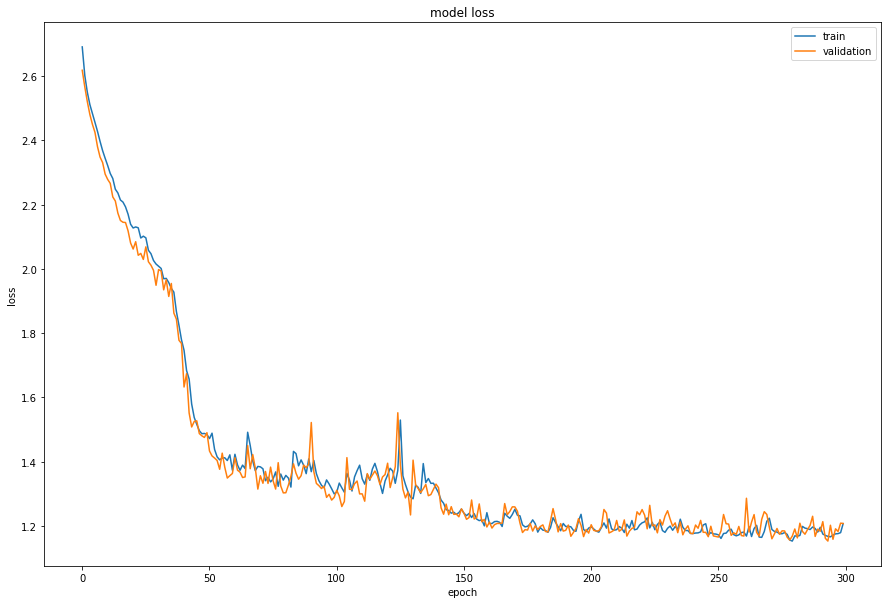

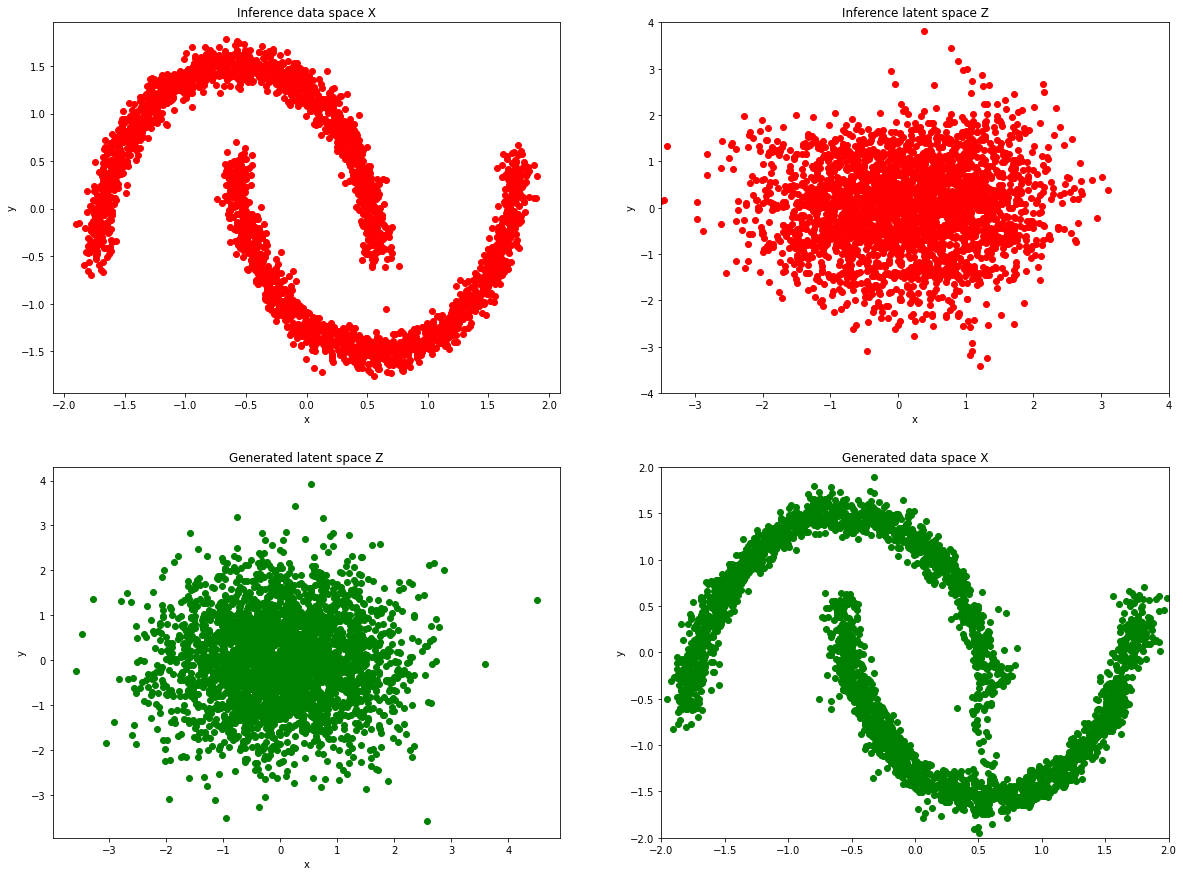

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])

# Test: Gaussian

In [9]:
def Gaussian(x, sigma, mu):
    return np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2))

x_test = np.linspace(-100,100,3000)
np.random.shuffle(x_test)

data_test = [[x_test[i],Gaussian(x_test[i],25,0)] for i in range(len(x_test))]
data_test = tf.convert_to_tensor(data_test)
print("Features mean: %.2f" % (data_test.numpy().mean()))
print("Features std: %.2f" % (data_test.numpy().std()))

norm.adapt(data_test)
normalized_data_test = norm(data_test)
print("Features mean: %.2f" % (normalized_data_test.numpy().mean()))
print("Features std: %.2f" % (normalized_data_test.numpy().std()))


model_test = RealNVP(num_coupling_layers=6)
model_test.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))


history_test = model_test.fit(normalized_data_test, batch_size=256, epochs=300, verbose=2, validation_split=0.2)



Features mean: 0.00
Features std: 40.84
Features mean: 0.00
Features std: 1.00
Epoch 1/300
10/10 - 6s - loss: 2.6380 - val_loss: 2.3737 - 6s/epoch - 564ms/step
Epoch 2/300
10/10 - 1s - loss: 2.2363 - val_loss: 2.0834 - 557ms/epoch - 56ms/step
Epoch 3/300
10/10 - 1s - loss: 1.9927 - val_loss: 1.8500 - 560ms/epoch - 56ms/step
Epoch 4/300
10/10 - 0s - loss: 1.7336 - val_loss: 1.6248 - 457ms/epoch - 46ms/step
Epoch 5/300
10/10 - 0s - loss: 1.5428 - val_loss: 1.4950 - 472ms/epoch - 47ms/step
Epoch 6/300
10/10 - 1s - loss: 1.4296 - val_loss: 1.4137 - 551ms/epoch - 55ms/step
Epoch 7/300
10/10 - 1s - loss: 1.3459 - val_loss: 1.3055 - 545ms/epoch - 54ms/step
Epoch 8/300
10/10 - 0s - loss: 1.2787 - val_loss: 1.2103 - 444ms/epoch - 44ms/step
Epoch 9/300
10/10 - 0s - loss: 1.1786 - val_loss: 1.1013 - 480ms/epoch - 48ms/step
Epoch 10/300
10/10 - 1s - loss: 1.0432 - val_loss: 0.9803 - 515ms/epoch - 52ms/step
Epoch 11/300
10/10 - 1s - loss: 0.8982 - val_loss: 0.8220 - 531ms/epoch - 53ms/step
Epoch 12

Epoch 90/300
10/10 - 1s - loss: -7.9924e-01 - val_loss: -9.0289e-01 - 514ms/epoch - 51ms/step
Epoch 91/300
10/10 - 0s - loss: -9.4235e-01 - val_loss: -1.0565e+00 - 451ms/epoch - 45ms/step
Epoch 92/300
10/10 - 1s - loss: -1.1089e+00 - val_loss: -1.1776e+00 - 539ms/epoch - 54ms/step
Epoch 93/300
10/10 - 1s - loss: -1.2006e+00 - val_loss: -1.1714e+00 - 564ms/epoch - 56ms/step
Epoch 94/300
10/10 - 0s - loss: -1.0851e+00 - val_loss: -1.0584e+00 - 488ms/epoch - 49ms/step
Epoch 95/300
10/10 - 0s - loss: -1.0726e+00 - val_loss: -1.1588e+00 - 474ms/epoch - 47ms/step
Epoch 96/300
10/10 - 1s - loss: -1.1856e+00 - val_loss: -1.2527e+00 - 561ms/epoch - 56ms/step
Epoch 97/300
10/10 - 1s - loss: -1.1947e+00 - val_loss: -1.2249e+00 - 603ms/epoch - 60ms/step
Epoch 98/300
10/10 - 0s - loss: -9.0681e-01 - val_loss: -1.2273e+00 - 441ms/epoch - 44ms/step
Epoch 99/300
10/10 - 1s - loss: -9.2372e-01 - val_loss: -4.1428e-01 - 536ms/epoch - 54ms/step
Epoch 100/300
10/10 - 1s - loss: -5.5916e-01 - val_loss: -9.

10/10 - 1s - loss: -1.4684e+00 - val_loss: -1.5223e+00 - 559ms/epoch - 56ms/step
Epoch 178/300
10/10 - 1s - loss: -1.4875e+00 - val_loss: -1.3965e+00 - 553ms/epoch - 55ms/step
Epoch 179/300
10/10 - 1s - loss: -1.3194e+00 - val_loss: -9.0706e-01 - 506ms/epoch - 51ms/step
Epoch 180/300
10/10 - 0s - loss: -8.2278e-01 - val_loss: -1.1187e+00 - 448ms/epoch - 45ms/step
Epoch 181/300
10/10 - 1s - loss: -1.3494e+00 - val_loss: -1.1994e+00 - 558ms/epoch - 56ms/step
Epoch 182/300
10/10 - 1s - loss: -9.1744e-01 - val_loss: -9.8492e-01 - 561ms/epoch - 56ms/step
Epoch 183/300
10/10 - 0s - loss: -1.2648e+00 - val_loss: -1.4834e+00 - 478ms/epoch - 48ms/step
Epoch 184/300
10/10 - 0s - loss: -1.3824e+00 - val_loss: -1.1812e+00 - 473ms/epoch - 47ms/step
Epoch 185/300
10/10 - 1s - loss: -7.1673e-01 - val_loss: -1.3010e+00 - 553ms/epoch - 55ms/step
Epoch 186/300
10/10 - 1s - loss: -1.0577e+00 - val_loss: -1.2700e+00 - 552ms/epoch - 55ms/step
Epoch 187/300
10/10 - 0s - loss: -1.2766e+00 - val_loss: -1.2943

Epoch 264/300
10/10 - 0s - loss: -1.6876e+00 - val_loss: -1.6338e+00 - 492ms/epoch - 49ms/step
Epoch 265/300
10/10 - 0s - loss: -1.8607e+00 - val_loss: -2.0102e+00 - 440ms/epoch - 44ms/step
Epoch 266/300
10/10 - 1s - loss: -2.0295e+00 - val_loss: -1.9819e+00 - 528ms/epoch - 53ms/step
Epoch 267/300
10/10 - 1s - loss: -1.8893e+00 - val_loss: -1.8029e+00 - 540ms/epoch - 54ms/step
Epoch 268/300
10/10 - 0s - loss: -1.9447e+00 - val_loss: -2.1304e+00 - 495ms/epoch - 50ms/step
Epoch 269/300
10/10 - 0s - loss: -2.1114e+00 - val_loss: -2.2266e+00 - 455ms/epoch - 46ms/step
Epoch 270/300
10/10 - 1s - loss: -2.0099e+00 - val_loss: -8.8702e-01 - 557ms/epoch - 56ms/step
Epoch 271/300
10/10 - 1s - loss: -3.4036e-01 - val_loss: 0.4725 - 550ms/epoch - 55ms/step
Epoch 272/300
10/10 - 0s - loss: -7.2209e-01 - val_loss: -1.4283e+00 - 478ms/epoch - 48ms/step
Epoch 273/300
10/10 - 0s - loss: -1.7700e+00 - val_loss: -1.9256e+00 - 487ms/epoch - 49ms/step
Epoch 274/300
10/10 - 1s - loss: -1.9353e+00 - val_loss

# Plot test: Gaussian

(-2.0, 2.0)

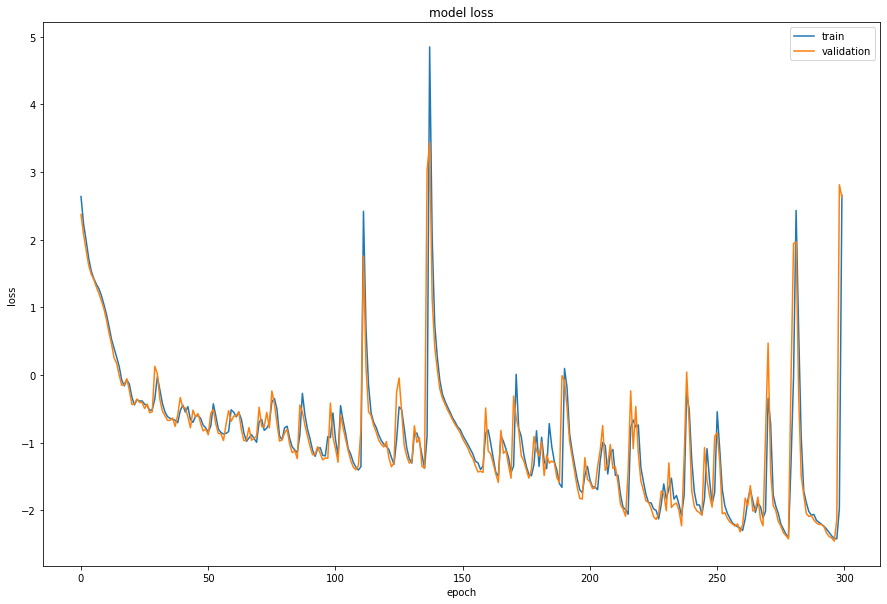

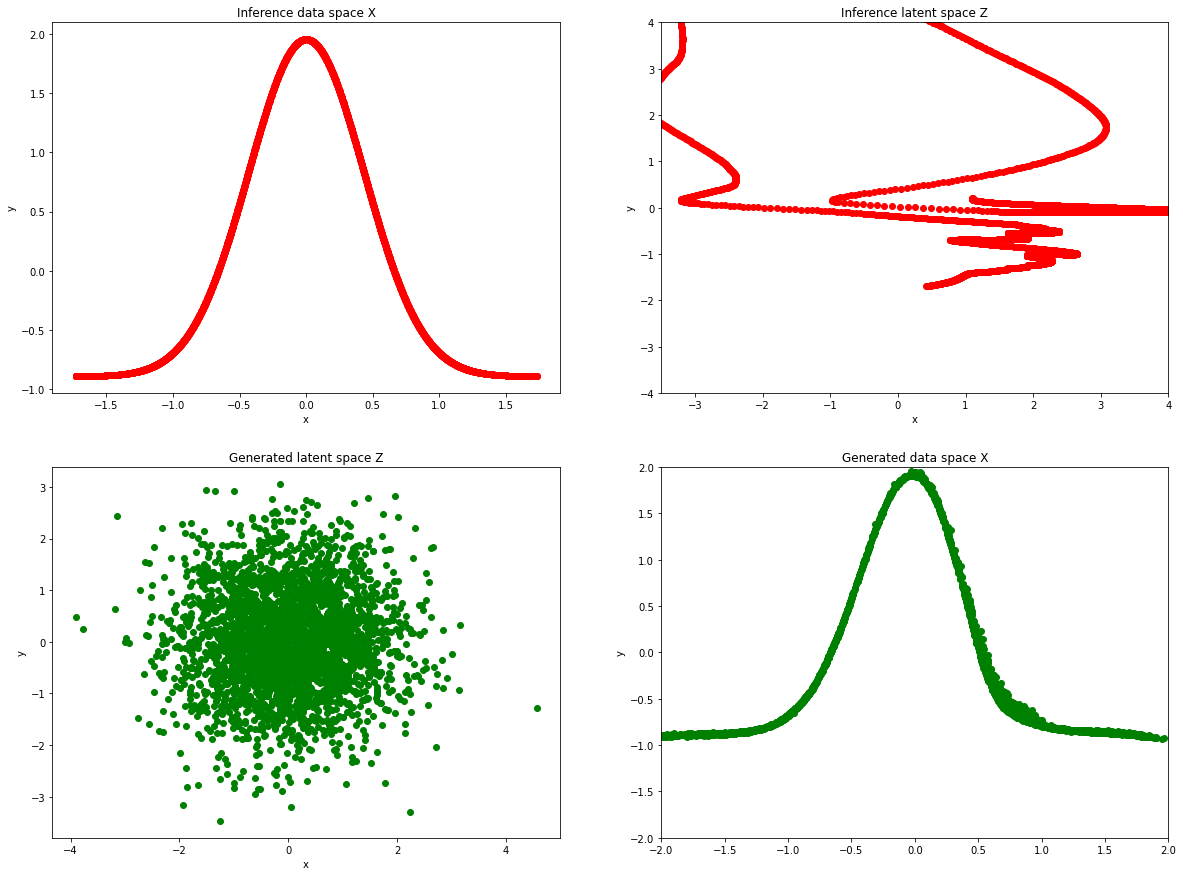

In [10]:
plt.figure(figsize=(15, 10))
plt.plot(history_test.history["loss"])
plt.plot(history_test.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z_test, _ = model_test(normalized_data_test)

# From latent space to data.
samples_test = model_test.distribution.sample(3000)
x_test, _ = model_test.predict(samples_test)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data_test[:, 0], normalized_data_test[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z_test[:, 0], z_test[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples_test[:, 0], samples_test[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])

# Test: function

In [11]:
def f(x):
    return np.sin(x)

x_test = np.linspace(-100,100,3000)
np.random.shuffle(x_test)


data_test2 = [[x_test[i],f(x_test[i])] for i in range(len(x_test))]

data_test2 = tf.convert_to_tensor(data_test2)
print("Features mean: %.2f" % (data_test2.numpy().mean()))
print("Features std: %.2f" % (data_test2.numpy().std()))

norm.adapt(data_test2)
normalized_data_test2 = norm(data_test2)
print("Features mean: %.2f" % (normalized_data_test2.numpy().mean()))
print("Features std: %.2f" % (normalized_data_test2.numpy().std()))

model_test2 = RealNVP(num_coupling_layers=6)
model_test2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history_test2 = model_test2.fit(normalized_data_test2, batch_size=256, epochs=200, verbose=2, validation_split=0.2)

Features mean: 0.00
Features std: 40.84
Features mean: 0.00
Features std: 1.00
Epoch 1/200
10/10 - 6s - loss: 2.8459 - val_loss: 2.8607 - 6s/epoch - 564ms/step
Epoch 2/200
10/10 - 1s - loss: 2.8400 - val_loss: 2.8567 - 547ms/epoch - 55ms/step
Epoch 3/200
10/10 - 1s - loss: 2.8394 - val_loss: 2.8556 - 554ms/epoch - 55ms/step
Epoch 4/200
10/10 - 0s - loss: 2.8391 - val_loss: 2.8599 - 479ms/epoch - 48ms/step
Epoch 5/200
10/10 - 0s - loss: 2.8405 - val_loss: 2.8569 - 449ms/epoch - 45ms/step
Epoch 6/200
10/10 - 1s - loss: 2.8353 - val_loss: 2.8530 - 549ms/epoch - 55ms/step
Epoch 7/200
10/10 - 1s - loss: 2.8392 - val_loss: 2.8545 - 545ms/epoch - 55ms/step
Epoch 8/200
10/10 - 0s - loss: 2.8353 - val_loss: 2.8491 - 470ms/epoch - 47ms/step
Epoch 9/200
10/10 - 0s - loss: 2.8247 - val_loss: 2.8435 - 474ms/epoch - 47ms/step
Epoch 10/200
10/10 - 1s - loss: 2.8159 - val_loss: 2.8255 - 553ms/epoch - 55ms/step
Epoch 11/200
10/10 - 1s - loss: 2.7907 - val_loss: 2.7948 - 532ms/epoch - 53ms/step
Epoch 12

Epoch 98/200
10/10 - 0s - loss: 2.2967 - val_loss: 2.3189 - 452ms/epoch - 45ms/step
Epoch 99/200
10/10 - 0s - loss: 2.2988 - val_loss: 2.3213 - 452ms/epoch - 45ms/step
Epoch 100/200
10/10 - 0s - loss: 2.3141 - val_loss: 2.3448 - 452ms/epoch - 45ms/step
Epoch 101/200
10/10 - 0s - loss: 2.3042 - val_loss: 2.3374 - 456ms/epoch - 46ms/step
Epoch 102/200
10/10 - 1s - loss: 2.2928 - val_loss: 2.3066 - 504ms/epoch - 50ms/step
Epoch 103/200
10/10 - 1s - loss: 2.2785 - val_loss: 2.3202 - 567ms/epoch - 57ms/step
Epoch 104/200
10/10 - 1s - loss: 2.2790 - val_loss: 2.3354 - 751ms/epoch - 75ms/step
Epoch 105/200
10/10 - 1s - loss: 2.2767 - val_loss: 2.3206 - 730ms/epoch - 73ms/step
Epoch 106/200
10/10 - 1s - loss: 2.2692 - val_loss: 2.3130 - 655ms/epoch - 65ms/step
Epoch 107/200
10/10 - 1s - loss: 2.2748 - val_loss: 2.2992 - 558ms/epoch - 56ms/step
Epoch 108/200
10/10 - 0s - loss: 2.2641 - val_loss: 2.3219 - 368ms/epoch - 37ms/step
Epoch 109/200
10/10 - 0s - loss: 2.2964 - val_loss: 2.3206 - 364ms/

Epoch 195/200
10/10 - 0s - loss: 2.2444 - val_loss: 2.2663 - 412ms/epoch - 41ms/step
Epoch 196/200
10/10 - 1s - loss: 2.2413 - val_loss: 2.2483 - 622ms/epoch - 62ms/step
Epoch 197/200
10/10 - 1s - loss: 2.2436 - val_loss: 2.2606 - 506ms/epoch - 51ms/step
Epoch 198/200
10/10 - 0s - loss: 2.2506 - val_loss: 2.2586 - 372ms/epoch - 37ms/step
Epoch 199/200
10/10 - 0s - loss: 2.2389 - val_loss: 2.2542 - 364ms/epoch - 36ms/step
Epoch 200/200
10/10 - 0s - loss: 2.2330 - val_loss: 2.2514 - 367ms/epoch - 37ms/step


# Plot test: function

(-2.0, 2.0)

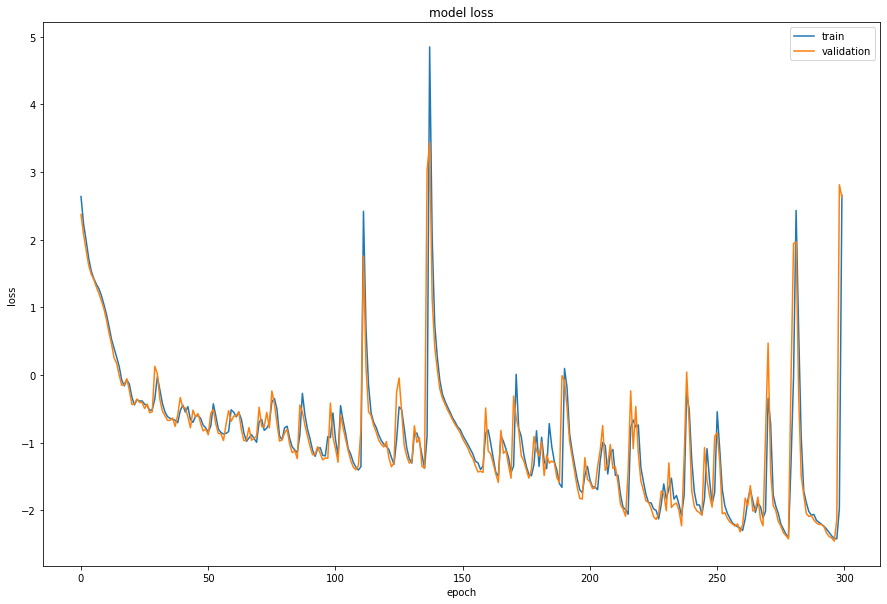

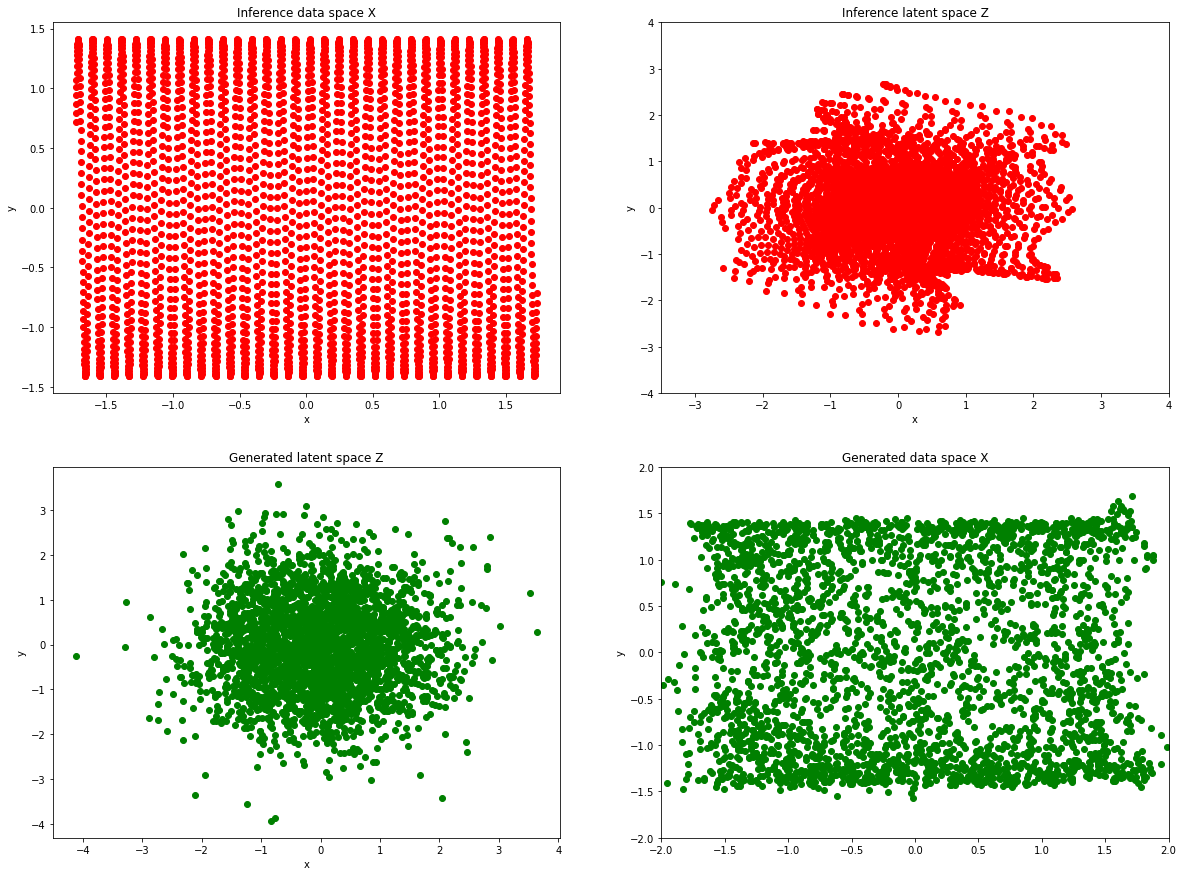

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(history_test.history["loss"])
plt.plot(history_test.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z_test2, _ = model_test2(normalized_data_test2)

# From latent space to data.
samples_test2 = model_test2.distribution.sample(3000)
x_test2, _ = model_test2.predict(samples_test2)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data_test2[:, 0], normalized_data_test2[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z_test2[:, 0], z_test2[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples_test2[:, 0], samples_test2[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x_test2[:, 0], x_test2[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])